IMPORTS

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import math

GLOBAL VARIABLES

In [2]:
START = 'S'  # Start -> nó inicial (canto superior esquerdo)
END = 'E'  # End -> nó final (canto inferior direito)
TERRA = 'T'  # Terra -> movimento para este nó tem custo 1
AGUA = 'A'  # Agua -> movimento para este nó tem custo 3
BARREIRA = 'B'  # Barreira -> can't move here
FRONTEIRA = 'F'  # Fronteira -> can't move here

CLASSES

In [3]:
class Node:
    def __init__(self, name, pos, cost_so_far, heuristic, path):
        self.name = name
        self.pos = pos
        self.cost_so_far = cost_so_far
        self.heuristic = heuristic
        self.path = path
        self.visited = False
        self.done = False
    
    def __str__(self):
        return f'{self.name} | {self.pos} | {self.cost_so_far} | {self.heuristic} | {self.combined_cost}\n{self.path}'
    
    def __eq__(self, obj):
        return obj.name == self.name and obj.pos == self.pos
    
    @property
    def combined_cost(self):
        return self.cost_so_far + self.heuristic

In [4]:
class Node_Structures:
    def __init__(self, init, grid):
        self.counter = 0
        self.done = []
        self.q = [init]
        self.node_map = {init: Node(grid[0][0], init, 0, 0, [init])}
        for (y, line) in enumerate(grid):
            for (x, _) in enumerate(line):
                if (y, x) != init:
                    pos = (y, x)
                    heuristic = calculate_heuristic_distance(pos, GOAL)
                    self.node_map[pos] = Node(grid[y][x], pos, 99999, heuristic, [])

    def get_node_from_queue(self, pos):
        return self.node_map[pos]

    def get_graph_map_list(self):
        map = [[''] * 100 for i in range(100)]
        for pos in self.node_map:
            if self.node_map[pos].done:
                map[pos[0]][pos[1]] = 'D'
            elif self.node_map[pos].visited:
                map[pos[0]][pos[1]] = 'V'
            else:
                map[pos[0]][pos[1]] = self.node_map[pos].name
        return map

FUNCTIONS

+ Get info from environment file

In [5]:
def read_environment_file(file_name):
    with open(file_name) as fp:
        return fp.readlines()

In [6]:
def process_environment_file_info(lines):
    lines_info = []
    
    for line in lines[1:]:  # ignore 1st line: positions
        cleared_line = line[:-1]  # remove \n
        line_info = cleared_line.split(',')[1:]
        lines_info.append(line_info)

    # print(lines_info)
    return lines_info

+ Calculate heuristic

In [7]:
# positions: (x, y)
def calculate_heuristic_distance(initial_pos, final_pos):
    horizontal_distance = abs(final_pos[0] - initial_pos[0])
    vertical_distance = abs(final_pos[1] - initial_pos[1])
    return max(horizontal_distance, vertical_distance)

+ Get possible move positions

In [8]:
def get_possible_move_positions(h):
    return [(h[0] - 1, h[1] - 1), (h[0] - 1, h[1]), (h[0] - 1, h[1] + 1),
            (h[0], h[1] - 1),                       (h[0], h[1] + 1),
            (h[0] + 1, h[1] - 1), (h[0] + 1, h[1]), (h[0] + 1, h[1] + 1),]

+ Vizualize environment as map

In [9]:
def visualize_env(map, counter):
    map_envir = pd.DataFrame(map)
    map_env_num = map_envir.replace(['T', 'F', 'S', 'E', 'A', 'B', 'V', 'D'], [0, 1, 2, 2, 3, 1, 4, 5])
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(map_env_num)
    f.savefig("output/map_at_"+ str(counter)+ ".png")

+ A* Algorithm

In [10]:
def a_star_algo(node_strucures, goal):
    node_map = node_strucures.node_map
    done = node_strucures.done
    q = node_strucures.q

    if node_structures.counter % 10 == 0:
        visualize_env(node_structures.get_graph_map_list(), int(node_structures.counter / 10))

    h = q[0]
    #print("\nHEAD -> ", node_map[h])
    #print('q = [', end='')
    #for (i, n) in enumerate(q):
        #print(f'{node_map[n].pos} {node_map[n].combined_cost}', end=(', ' if i != len(q) - 1 else ']\n'))
    #print('done = ', done)
    done.append(h)
    node_map[h].done = True
    q.pop(0)

    if h == goal:
        print("GG LETS GOOOOOOOOOOOOOOOOOOOOOOOO")

    #print(f'head {h} -> {node_map[h].cost_so_far}')
    possible_move_positions = get_possible_move_positions(h)
    #print(f'possible_move_positions -> {possible_move_positions}')
    for pos in possible_move_positions:

        # Outside map - should check over 100 as well
        if pos[0] < 0 or pos[1] < 0:
            continue

        node = node_map[pos]
        #print(f'{node.pos} actual move -> {node.name not in [FRONTEIRA, BARREIRA] and node.pos not in done}')
        if node.name not in [FRONTEIRA, BARREIRA] and node.pos not in done:
            node.visited = True
            #print(f'{node.name} {node.pos}: {node.cost_so_far} + {node.heuristic} = {node.combined_cost} -> ', end='')
            if node.cost_so_far > node_map[h].cost_so_far + (3 if node.name == AGUA else 1):
                node.cost_so_far = node_map[h].cost_so_far + (3 if node.name == AGUA else 1)
            #print(f'{node.cost_so_far} + {node.heuristic} = {node.combined_cost} ')
            node.path = node_map[h].path + [node.pos]
            if node.pos not in q:
                q.append(node.pos)
        
    node_strucures.q = list(set(q))
    node_strucures.q.sort(key=lambda x: node_map[x].combined_cost)
    node_strucures.counter += 1
    a_star_algo(node_strucures, goal)


MAIN CODE

+ Create Initial Environment Grid

In [11]:
lines = read_environment_file('sample-environment.csv')
lines_info = process_environment_file_info(lines)
grid = np.array(lines_info, dtype=object)

In [12]:
# pd.DataFrame(lines_info)

+ Initializations needed to A* Algorithm

In [13]:
INIT = (0, 0)  # initial state
GOAL = (99, 99)  # goal state

In [14]:
# done = [] # list of processed nodes
node_structures = Node_Structures(INIT, grid)

+ Initialize queue **q** with initial node and default value for the rest

In [15]:
"""q = []
q.append(INIT)

node_map = {}
node_map[INIT] = Node(grid[0][0], INIT, 0, 0, [INIT])

for (y, line) in enumerate(grid):
    for (x, _) in enumerate(line):
        if x != 0 or y != 0:
            pos = (y, x)
            heuristic = calculate_heuristic_distance(pos, GOAL)
            node_map[pos] = Node(grid[y][x], pos, 99999, heuristic, [])
            # q.append(pos)"""

'q = []\nq.append(INIT)\n\nnode_map = {}\nnode_map[INIT] = Node(grid[0][0], INIT, 0, 0, [INIT])\n\nfor (y, line) in enumerate(grid):\n    for (x, _) in enumerate(line):\n        if x != 0 or y != 0:\n            pos = (y, x)\n            heuristic = calculate_heuristic_distance(pos, GOAL)\n            node_map[pos] = Node(grid[y][x], pos, 99999, heuristic, [])\n            # q.append(pos)'

+ While loop with the actual algorithm

In [16]:
"""while q:
    e = []
    h = get_node_from_queue(q[0])  # head
    print(f'# # # # # # HEAD:\n{h}')
    r = q[1:]  # rest
    
    if h.name == END:
        print('Got to the end:')
        print(f'Path -> {h.path}')
        break  # TODO: check
    else:
        print(f'Expanding -> {h.pos}')
        e_nodes = expand_from_head_node(h)
    
    for node in e_nodes:
        e.append(node.pos)
        q_node = get_node_from_queue(node.pos)
        if q_node.cost_so_far > node.cost_so_far:
            # print(f'Closer path to {node.pos} | cost_so_far {q_node.cost_so_far} -> {node.cost_so_far}\n\tpath: {node.path}')
            q_node.cost_so_far = node.cost_so_far
            q_node.path = node.path
    print('Expand to List -> ', e)

    done.append(h.pos)
    print(f'Done -> ', done)
    
    q = e + r
    
    print(f'Q before sort -> ', q[:10])
    q.sort(key=lambda x: node_map[x].combined_cost)
    print(f'Q after sort -> ', q[:10])"""

"while q:\n    e = []\n    h = get_node_from_queue(q[0])  # head\n    print(f'# # # # # # HEAD:\n{h}')\n    r = q[1:]  # rest\n    \n    if h.name == END:\n        print('Got to the end:')\n        print(f'Path -> {h.path}')\n        break  # TODO: check\n    else:\n        print(f'Expanding -> {h.pos}')\n        e_nodes = expand_from_head_node(h)\n    \n    for node in e_nodes:\n        e.append(node.pos)\n        q_node = get_node_from_queue(node.pos)\n        if q_node.cost_so_far > node.cost_so_far:\n            # print(f'Closer path to {node.pos} | cost_so_far {q_node.cost_so_far} -> {node.cost_so_far}\n\tpath: {node.path}')\n            q_node.cost_so_far = node.cost_so_far\n            q_node.path = node.path\n    print('Expand to List -> ', e)\n\n    done.append(h.pos)\n    print(f'Done -> ', done)\n    \n    q = e + r\n    \n    print(f'Q before sort -> ', q[:10])\n    q.sort(key=lambda x: node_map[x].combined_cost)\n    print(f'Q after sort -> ', q[:10])"

C:\Users\tiago\AppData\Local\Temp\ipykernel_24908\1748649834.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize=(16, 10))


KeyboardInterrupt: 

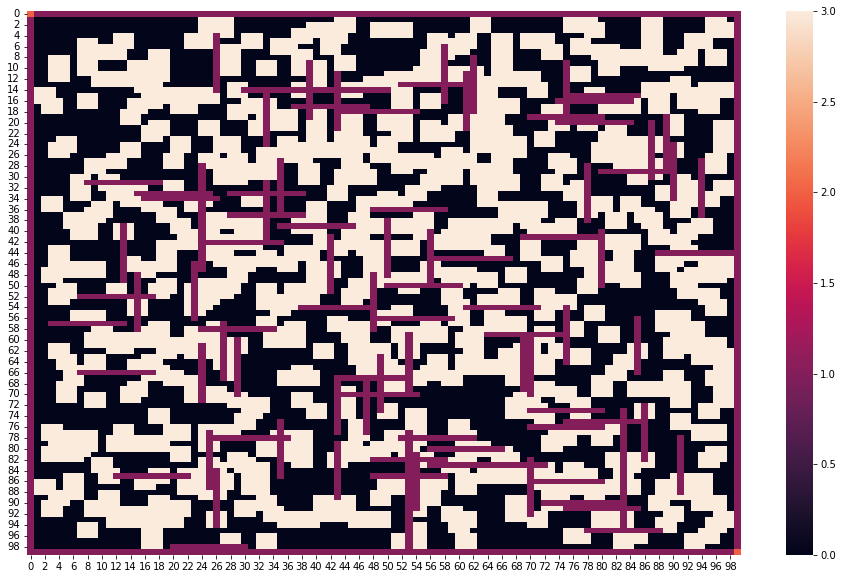

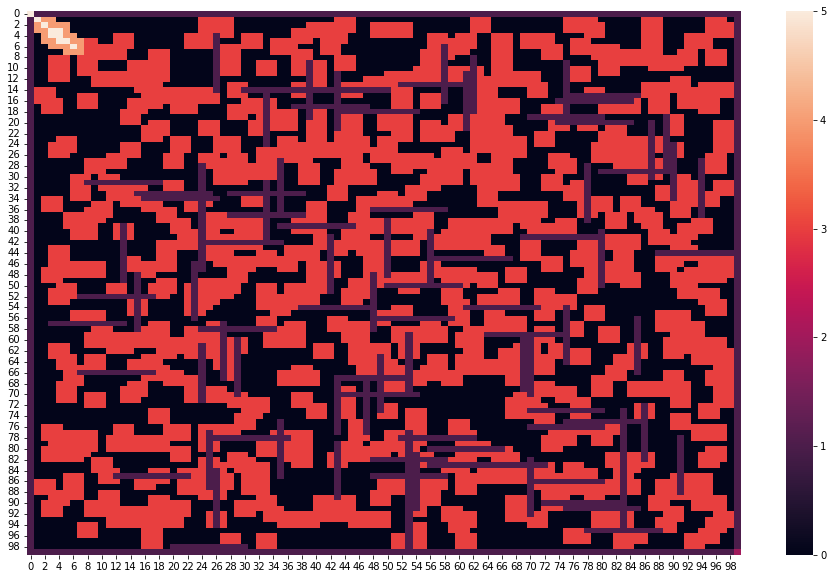

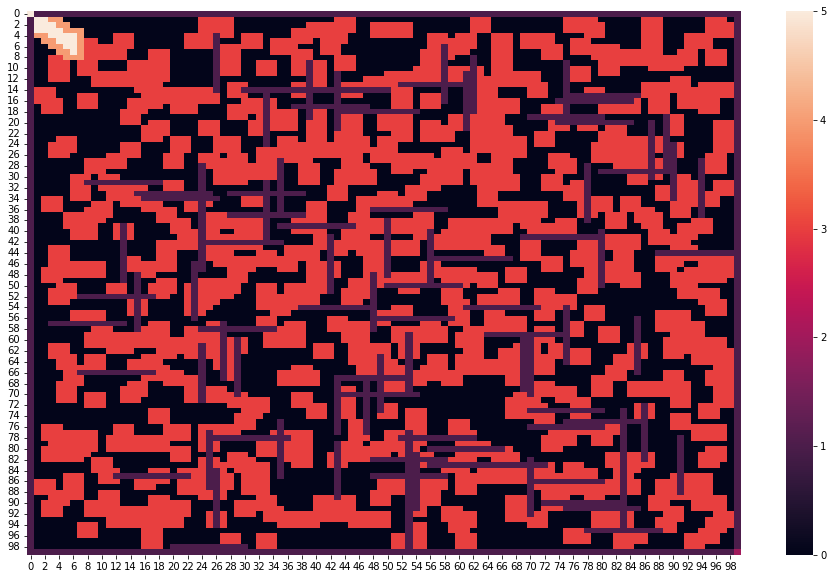

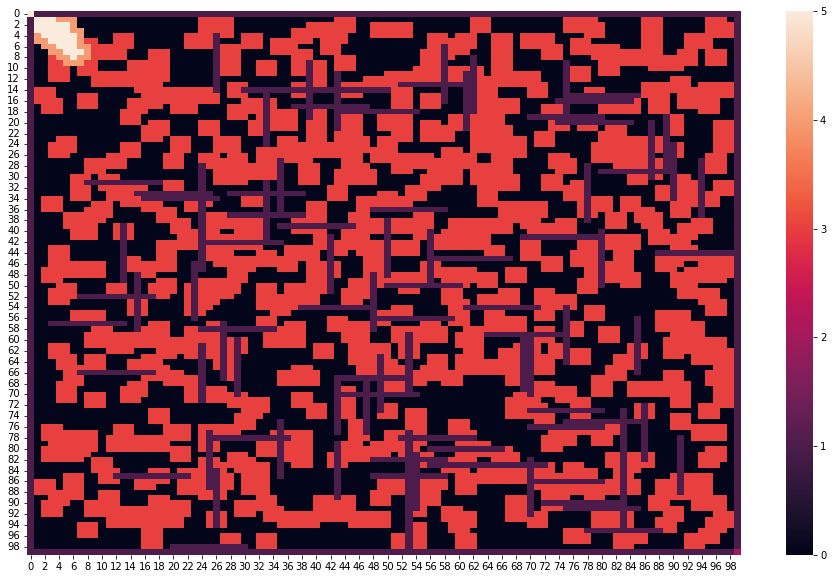

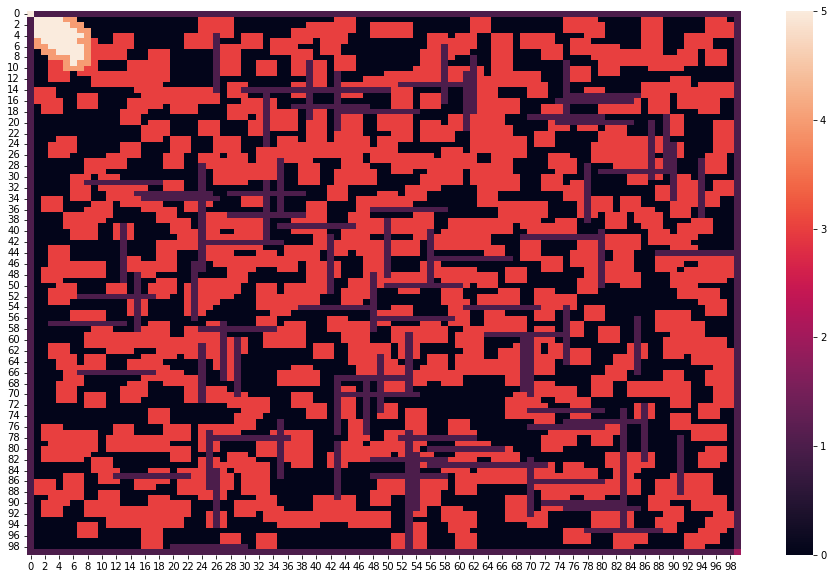

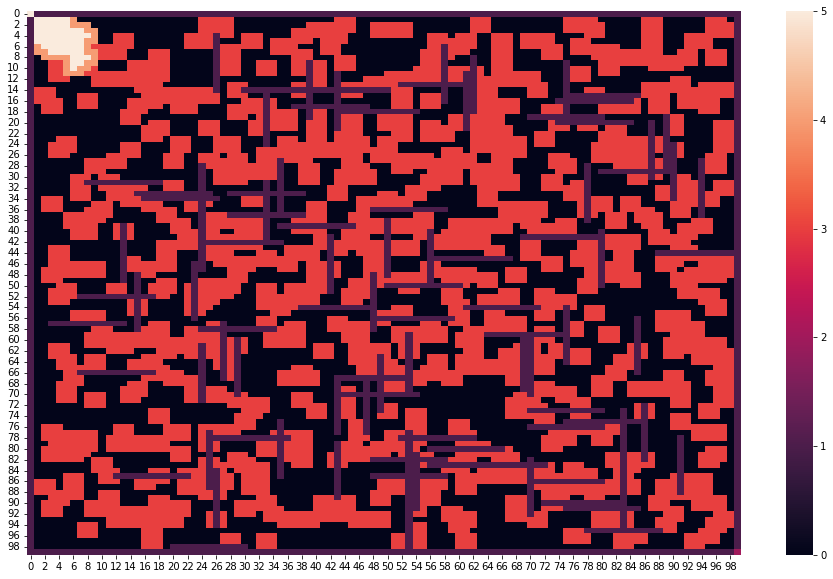

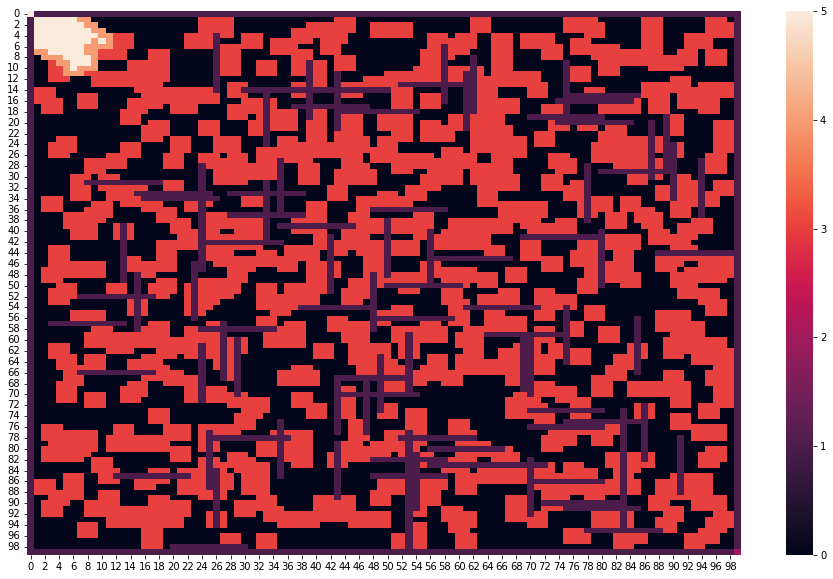

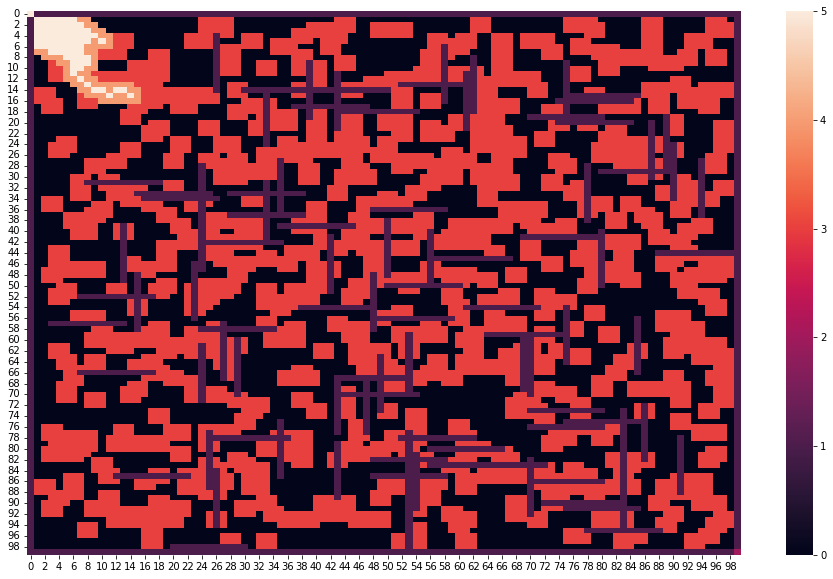

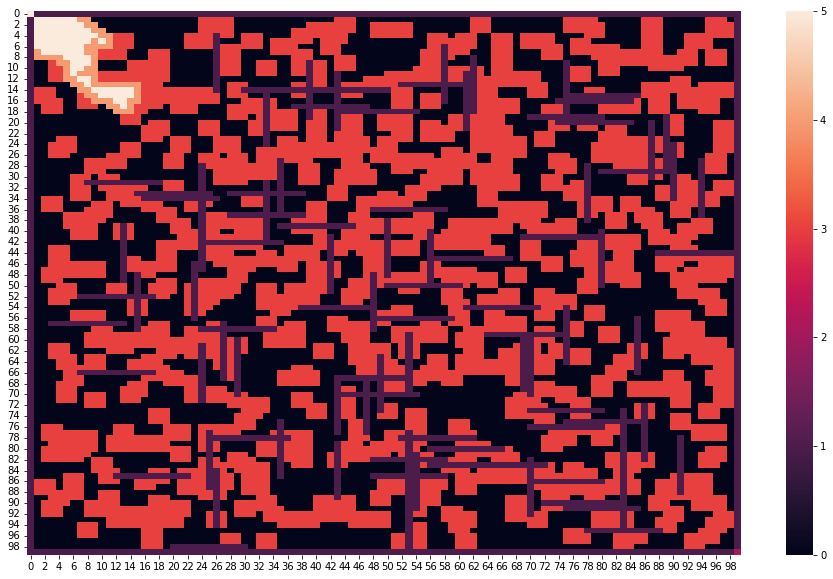

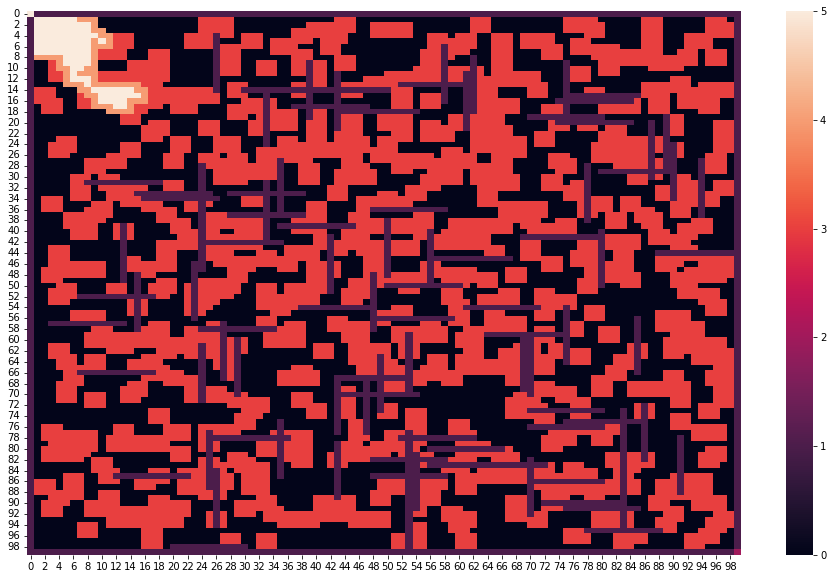

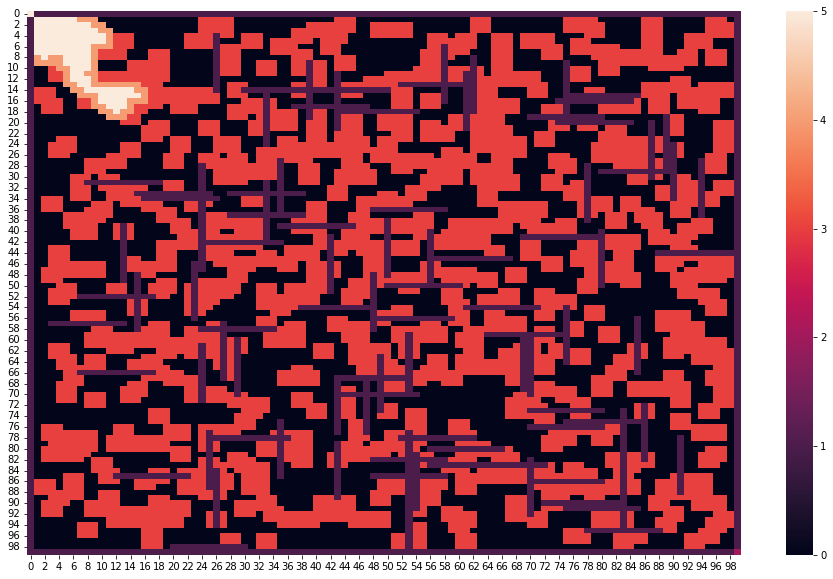

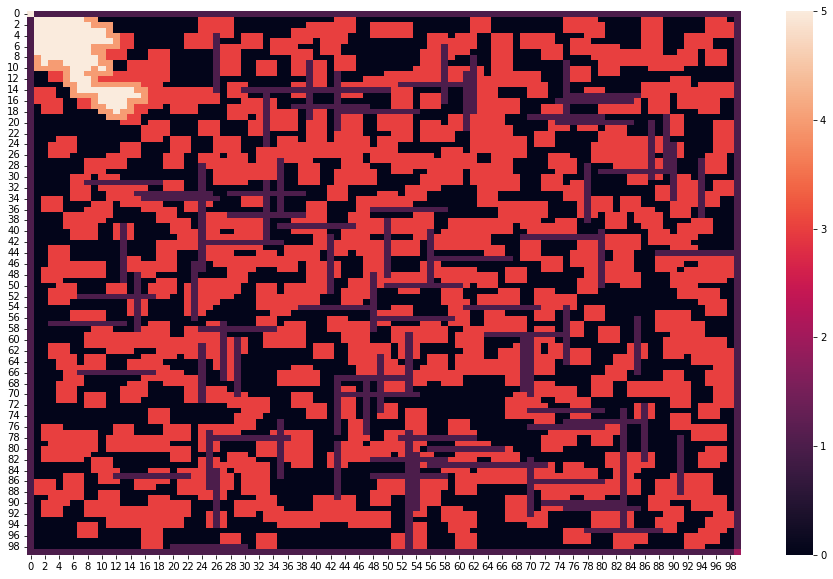

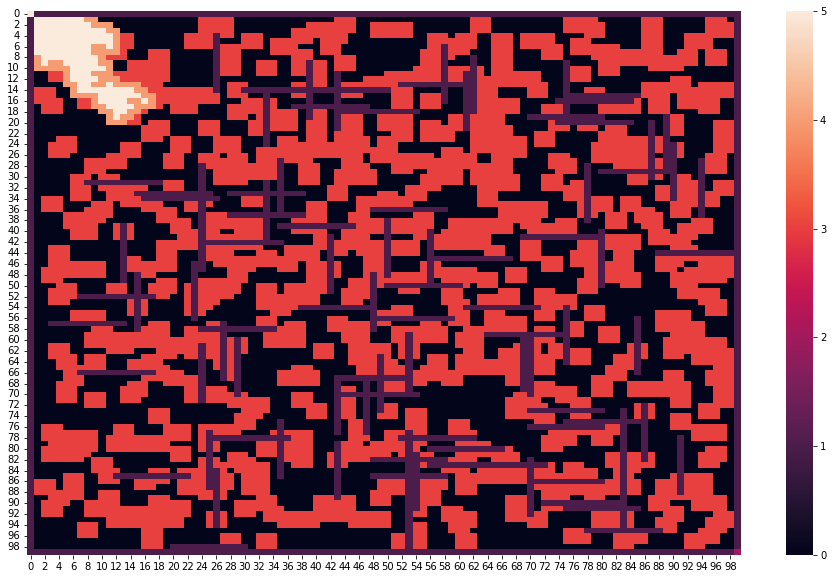

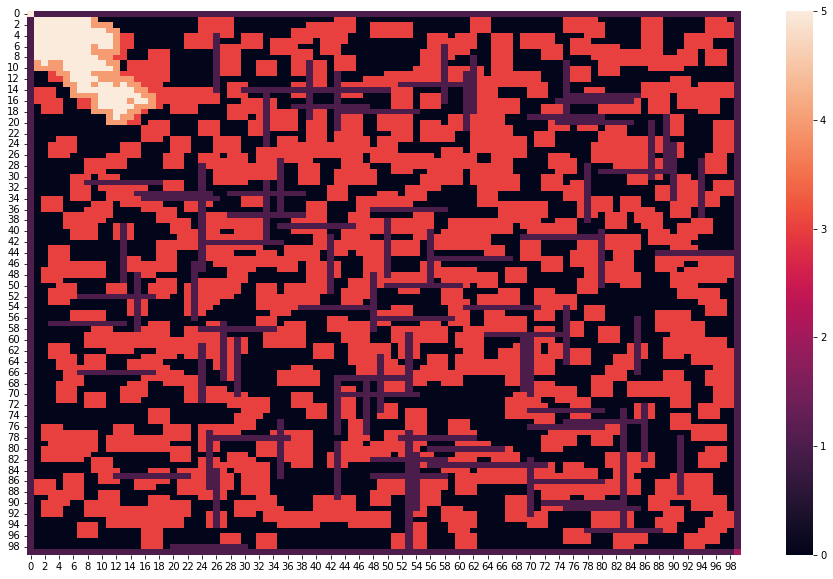

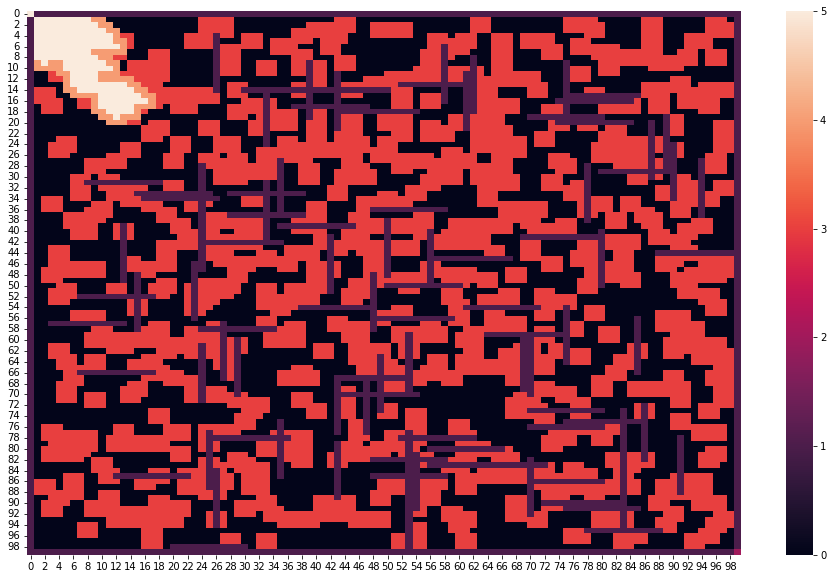

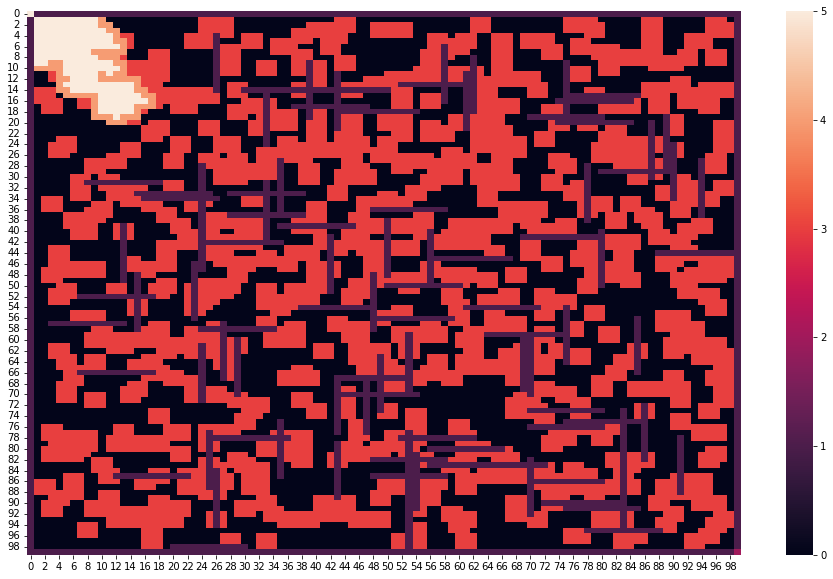

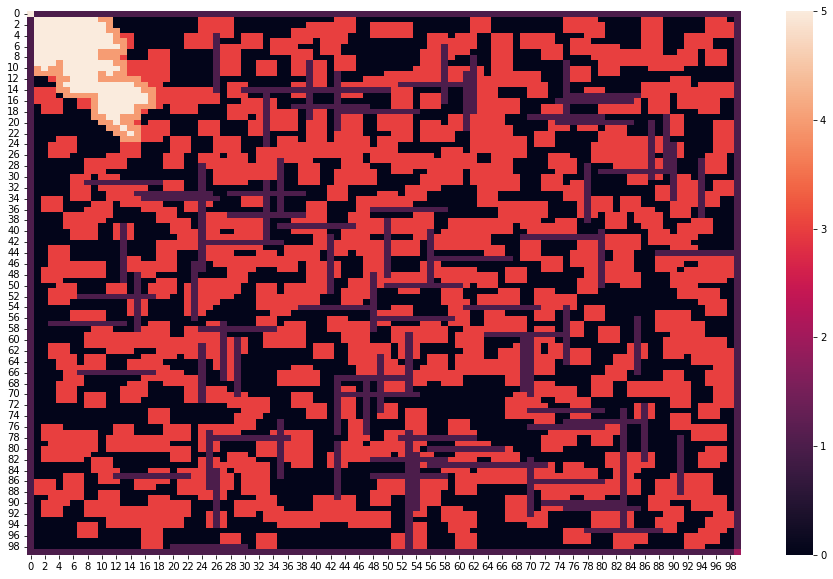

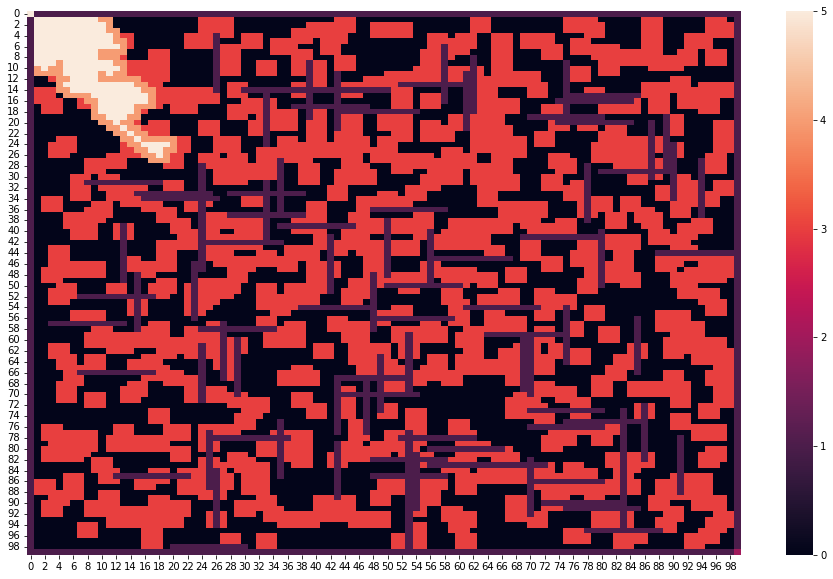

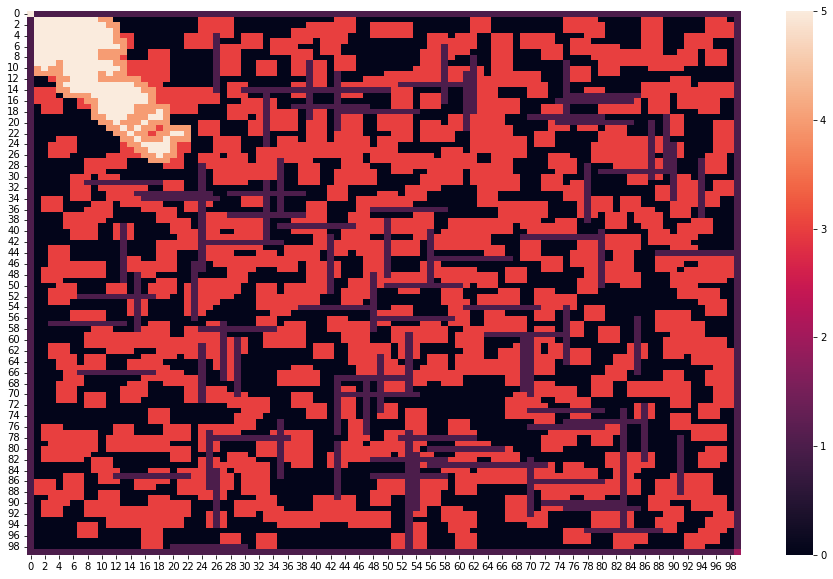

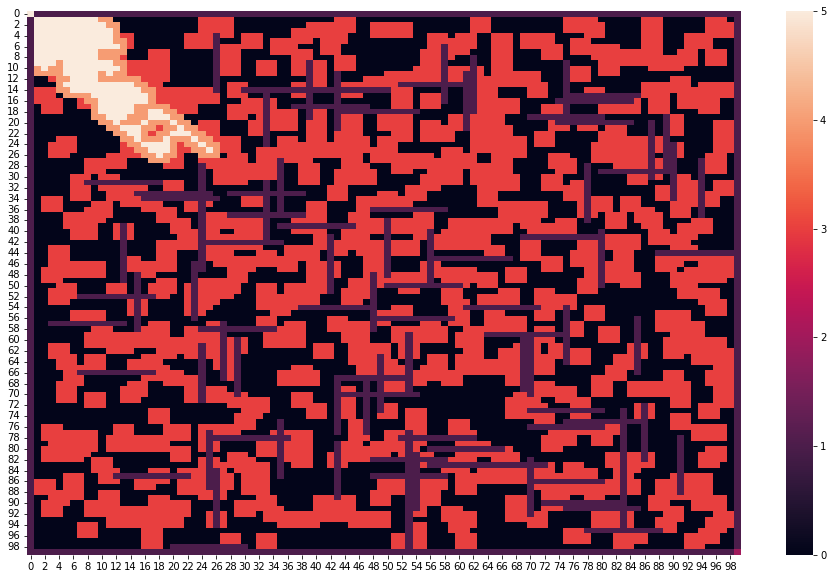

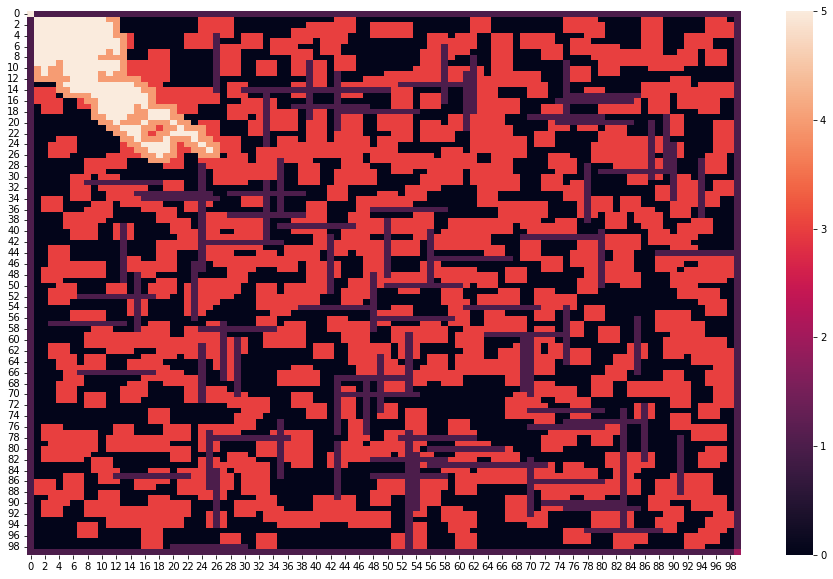

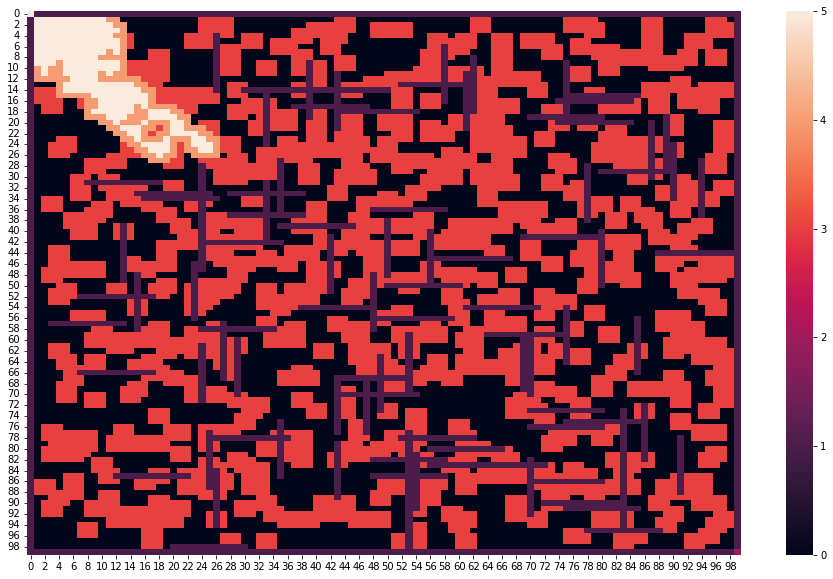

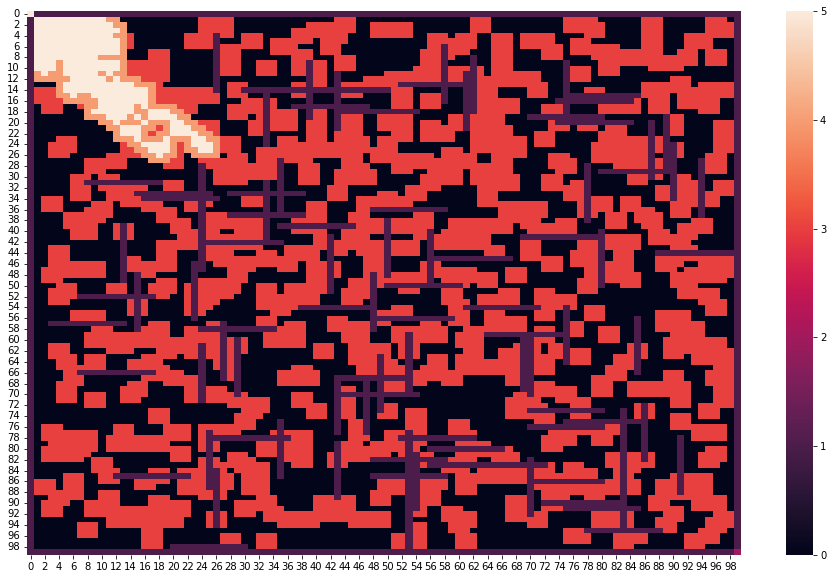

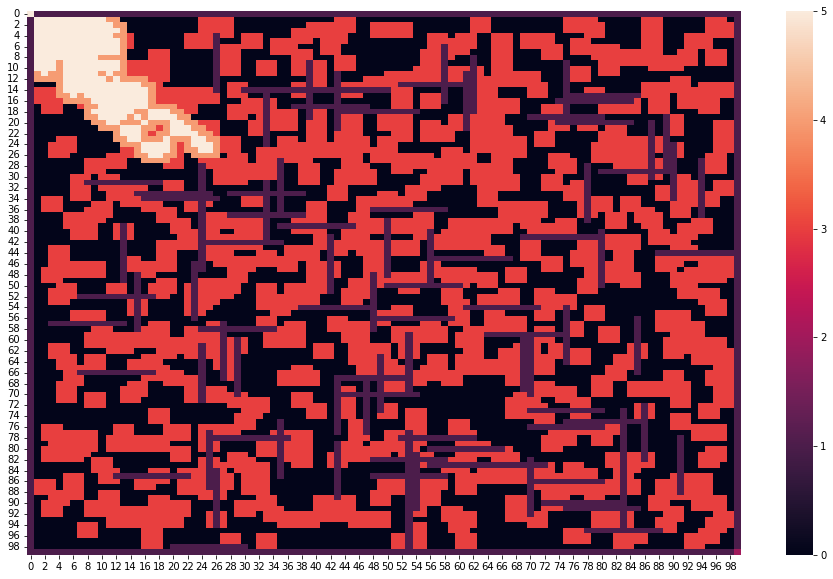

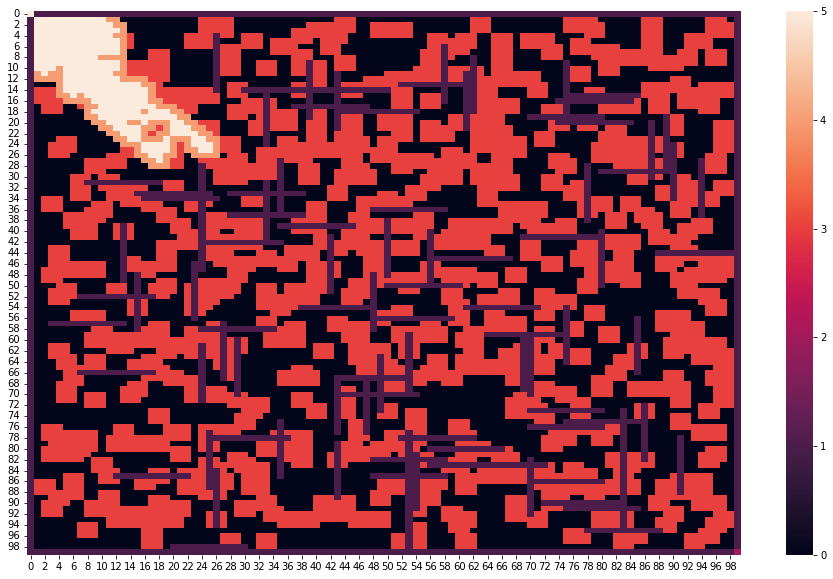

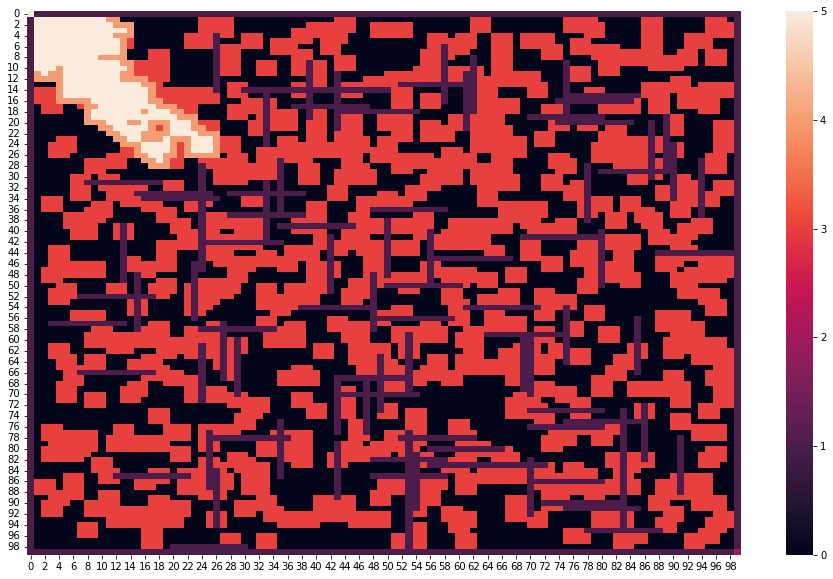

In [17]:
a_star_algo(node_structures, GOAL)